# DAT500 - FinalProject, Flight Delay Prediction

Group Members:

    - Brage Solheim
    - Yohannes D. Kassaye

## Introduction

So far we have used map reduce jobs to find null values in our data, find mean and mode of each column, and fill null values with mean or mode.

We will be predicting flight delays based on data that is available prior to the day of the flight. <br>
Such data could be weather, airport, airline, origin and destination, and other factors.

## Initlization

In [1]:
import findspark
findspark.init()
findspark.find()

'/usr/local/spark'

In [37]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
ORIGINAL_DATA_PATH = "hdfs:///data/airline_delay_data.csv"
CLEANED_DATA_PATH = "hdfs:///data/airline_delay_data_cleaned.csv"

TEST_DATA_ORIGINAL_PATH = "/data/2015.sample.csv"
TEST_DATA_CLEANED_PATH = "/data/2015.sample.cleaned.csv"

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pyspark
conf = pyspark.SparkConf().setAll([("spark.driver.maxResultSize", '4g'), ("spark.sql.execution.arrow.pyspark.enabled", 'true')])

In [6]:
spark = (SparkSession
            .builder
            .master("yarn") # for cluster
            # .master("local[*]") # for local testing
            .config(conf=conf)
            .appName("Flight-delay-prediction")
            .getOrCreate())

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-04-21 21:48:10,838 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-04-21 21:48:20,384 WARN yarn.Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [8]:
print(sc.getConf().getAll())

[('spark.ui.showConsoleProgress', 'true'), ('spark.app.id', 'application_1645016454320_0108'), ('spark.app.startTime', '1650573232844'), ('spark.driver.port', '37911'), ('spark.sql.warehouse.dir', 'file:/home/ubuntu/DAT500-FinalProject/spark/spark-warehouse'), ('spark.executor.id', 'driver'), ('spark.app.name', 'Flight-delay-prediction'), ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_URI_BASES', 'http://namenode:8088/proxy/application_1645016454320_0108'), ('spark.driver.host', 'namenode'), ('spark.master', 'yarn'), ('spark.executorEnv.PYTHONPATH', '/usr/local/spark/python/:<CPS>{{PWD}}/pyspark.zip<CPS>{{PWD}}/py4j-0.10.9.3-src.zip'), ('spark.rdd.compress', 'True'), ('spark.serializer.objectStreamReset', '100'), ('spark.submit.pyFiles', ''), ('spark.yarn.isPython', 'true'), ('spark.submit.deployMode', 'client'), ('spark.ui.proxyBase', '/proxy/application_1645016454320_0108'), ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY

In [7]:
from pyspark.sql.types import StructType, StructField, StringType, DateType, DoubleType

In [10]:
features = ["FL_DATE","OP_CARRIER","OP_CARRIER_FL_NUM","ORIGIN","DEST","CRS_DEP_TIME","DEP_TIME","DEP_DELAY","TAXI_OUT","WHEELS_OFF","WHEELS_ON","TAXI_IN","CRS_ARR_TIME","ARR_TIME","ARR_DELAY","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","AIR_TIME","DISTANCE","CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]
nullable=False
schema = StructType([
    StructField("FL_DATE", DateType(), nullable), StructField("OP_CARRIER", StringType(), nullable), StructField("OP_CARRIER_FL_NUM", DoubleType(), nullable),
    StructField("ORIGIN", StringType(), nullable), StructField("DEST", StringType(), nullable), StructField("CRS_DEP_TIME", DoubleType(), nullable),
    StructField("DEP_TIME", DoubleType(), nullable), StructField("DEP_DELAY", DoubleType(), nullable), StructField("TAXI_OUT", DoubleType(), nullable),
    StructField("WHEELS_OFF", DoubleType(), nullable), StructField("WHEELS_ON", DoubleType(), nullable), StructField("TAXI_IN", DoubleType(), nullable),
    StructField("CRS_ARR_TIME", DoubleType(), nullable), StructField("ARR_TIME", DoubleType(), nullable), StructField("ARR_DELAY", DoubleType(), nullable),
    StructField("CANCELLED", DoubleType(), nullable), StructField("DIVERTED", DoubleType(), nullable), StructField("CRS_ELAPSED_TIME", DoubleType(), nullable),
    StructField("ACTUAL_ELAPSED_TIME", DoubleType(), nullable), StructField("AIR_TIME", DoubleType(), nullable), StructField("DISTANCE", DoubleType(), nullable),
    StructField("CARRIER_DELAY", DoubleType(), nullable), StructField("WEATHER_DELAY", DoubleType(), nullable), StructField("NAS_DELAY", DoubleType(), nullable),
    StructField("SECURITY_DELAY", DoubleType(), nullable), StructField("LATE_AIRCRAFT_DELAY", DoubleType(), nullable)])

In [11]:
df = spark.read.csv(CLEANED_DATA_PATH, header=True, schema=schema, inferSchema=False)
df.to_pandas_on_spark().head()

2022-04-21 20:34:35,735 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-04-21 20:34:35,786 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-04-21 20:34:35,826 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2016-09-25,AA,2622.0,EGE,DFW,800.0,749.0,-11.0,11.0,800.0,1049.0,15.0,1110.0,1104.0,-6.0,0.0,0.0,130.0,135.0,109.0,721.0,19.62,3.04,15.08,0.09,24.72
1,2016-09-25,AA,2623.0,DFW,TPA,1830.0,1915.0,45.0,20.0,1935.0,2243.0,3.0,2155.0,2246.0,51.0,0.0,0.0,145.0,151.0,128.0,929.0,0.00,0.00,6.00,0.00,45.00
2,2016-09-25,AA,2625.0,MCO,DFW,935.0,930.0,-5.0,12.0,942.0,1052.0,17.0,1124.0,1109.0,-15.0,0.0,0.0,169.0,159.0,130.0,985.0,19.62,3.04,15.08,0.09,24.72
3,2016-09-25,AA,2626.0,DFW,FLL,1429.0,1710.0,161.0,28.0,1738.0,2054.0,4.0,1814.0,2058.0,164.0,0.0,0.0,165.0,168.0,136.0,1119.0,15.00,0.00,3.00,0.00,146.00
4,2016-09-25,AA,2626.0,TUS,DFW,915.0,910.0,-5.0,10.0,920.0,1337.0,14.0,1328.0,1351.0,23.0,0.0,0.0,133.0,161.0,137.0,813.0,0.00,0.00,23.00,0.00,0.00


## Data Engineering

In [12]:
df = df.repartition(24)

In [8]:
from pyspark.sql import functions as F

As we see the order of the data is completely mixed up, so our header is in the middle of the data. <br>
We will have to find that header row, and then remove it from the data.

In [14]:
header_row = df.filter(F.col("FL_DATE").isNull())
header_row.to_pandas_on_spark()

2022-04-21 20:36:24,911 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-04-21 20:36:24,915 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-04-21 20:37:33,035 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,None,OP_CARRIER,NaN,ORIGIN,DEST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


When we infer the schema, the header row is not the same type as the rest of the rows, and therefore is converted to null. <br>
And we can use this fact to filter out the header row.

In [15]:
df = df.filter((F.col("FL_DATE").isNull() & F.col("OP_CARRIER").isNotNull() & F.col("ORIGIN").isNotNull() & F.col("DEST").isNotNull()) == False)

In [16]:
header_row = df.filter(F.col("FL_DATE").isNull())
print(header_row.count())

0


Next we will encode categorical columns, because we will be using them in our model.

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

categorical_columns = [col[0] for col in df.dtypes if col[1] == "string"]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_indexed", handleInvalid="keep").fit(df) for col in categorical_columns]

pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df).transform(df)
df_indexed.show(5)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+------------------+--------------+------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|OP_CARRIER_indexed|ORIGIN_indexed|DEST_indexed|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+------------------

We are also dealing with time series data, and therefore we need to encode the dates.

In [19]:
df_indexed = df_indexed.withColumn("FL_DATE", F.col("FL_DATE").cast("timestamp"))\
             .withColumn("FL_DATE_indexed", F.unix_timestamp(F.col("FL_DATE"), format="yyyy-MM-dd"))
df_indexed.show(5)

+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+------------------+--------------+------------+---------------+
|            FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|OP_CARRIER_indexed|ORIGIN_indexed|DEST_indexed|FL_DATE_indexed|
+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+------------

To make sure that our model understand the columns containing data such as Planned Departure Time, and Planned Arrival Time, we will convert them to time.

In [20]:
def Convert_time_to_string(time, date):

    time = str(int(time))
    if len(time) == 1:
        time = f"00:0{time[0]}"
    elif len(time) == 2:
        time = f"00:{time}"
    elif len(time) == 3:
        time = f"0{time[0]}:{time[1:]}"
    elif len(time) == 4:
        time = f"{time[0:2]}:{time[2:]}"
    
    if date != None:
        return f"{date} {time}"

    return time

udf_Convert_time_to_string = F.udf(Convert_time_to_string, StringType())

In [21]:
print(Convert_time_to_string(0.0, "2018-11-04"), # should be 2018-11-04 00:00
      Convert_time_to_string(4.0, "2018-11-04"), # should be  2018-11-04 00:04, because you cant have leading zeros
      Convert_time_to_string(23.0, "2018-11-04"), # should be  2018-11-04 00:23, because you cant have leading zeros
      Convert_time_to_string(808.0, "2018-11-04"), # should be  2018-11-04 08:08, because you cant have leading zeros
      Convert_time_to_string(1203.0, "2018-11-04")) # should be  2018-11-04 12:03

2018-11-04 00:00 2018-11-04 00:04 2018-11-04 00:23 2018-11-04 08:08 2018-11-04 12:03


In [23]:
df_indexed = df_indexed.withColumn("CRS_DEP_TIME_indexed", F.unix_timestamp(udf_Convert_time_to_string(F.col("CRS_DEP_TIME"), F.split(F.col("FL_DATE").cast("string"), " ").getItem(0)), format="yyyy-MM-dd HH:mm")) \
    .withColumn("CRS_ARR_TIME_indexed", F.unix_timestamp(udf_Convert_time_to_string(F.col("CRS_ARR_TIME"), F.split(F.col("FL_DATE").cast("string"), " ").getItem(0)), format="yyyy-MM-dd HH:mm"))
df_indexed.show(5, truncate=False)

+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+------------------+--------------+------------+---------------+--------------------+--------------------+
|FL_DATE            |OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|OP_CARRIER_indexed|ORIGIN_indexed|DEST_indexed|FL_DATE_indexed|CRS_DEP_TIME_indexed|CRS_ARR_TIME_indexed|
+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+--

We will try to predict whether or not the flight is delayed, so we will create a binary column, based on either departure delay or arrival delay.

In [24]:
df_indexed = df_indexed.withColumn("Delayed", F.when((F.col("DEP_DELAY") > 0) | (F.col("ARR_DELAY") > 0), 1).otherwise(0))
df_indexed.show(5, truncate=False)

+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+------------------+--------------+------------+---------------+--------------------+--------------------+-------+
|FL_DATE            |OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|OP_CARRIER_indexed|ORIGIN_indexed|DEST_indexed|FL_DATE_indexed|CRS_DEP_TIME_indexed|CRS_ARR_TIME_indexed|Delayed|
+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+-----

We also have some data regarding a flight being canceled, so we will remove any rows that have a value of 1 in the Cancelled column. <br>
given that it doesnt give us any information about the flight being delayed.

In [25]:
df_indexed.groupBy("CANCELLED").count().show()

+---------+--------+
|CANCELLED|   count|
+---------+--------+
|      0.0|23969781|
|      1.0|  355022|
+---------+--------+



In [26]:
df_indexed = df_indexed.where(F.col("CANCELLED") == 0)
df_indexed.show(5, truncate=False)

+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+------------------+--------------+------------+---------------+--------------------+--------------------+-------+
|FL_DATE            |OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|OP_CARRIER_indexed|ORIGIN_indexed|DEST_indexed|FL_DATE_indexed|CRS_DEP_TIME_indexed|CRS_ARR_TIME_indexed|Delayed|
+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+-----

Lastly we will remove columns containing data that is not available prior to the day of the flight. <br>

These columns are:

    - DEP_TIME - Actual Departure Time
    - DEP_DELAY - Total Delay on Departure in minutes
    - TAXI_OUT - Time between departure The time duration elapsed between departure from the origin airport gate and wheels off
    - WHEELS_OFF - The time point that the aircraft's wheels leave the ground.
    - WHEELS_ON - The time point that the aircraft'ss wheels touch on the ground.
    - TAXI_IN - The time duration elapsed between wheels-on and gate arrival at the destination airport.
    - ARR_TIME = Actual Arrival Time = ARRIVAL_TIME - SCHEDULED_ARRIVAL
    - ARR_DELAY = Total Delay on Arrival in minutes
    - DIVERTED = Aircraft landed on different airport that the one scheduled
    - AIR_TIME = The time duration between wheels_off and wheels_on time
    - DISTANCE = Distance between two airports
    - CARRIER_DELAY = Delay caused by the airline in minutes
    - NAS_DELAY = Delay caused by air system
    - SECURITY_DELAY = caused by security reasons
    - LATE_AIRCRAFT_DELAY = Delay caused by security

In [ ]:
# cols_to_remove = ["DEP_TIME", "DEP_DELAY", "TAXI_OUT", "WHEELS_OFF", "WHEELS_ON", "TAXI_IN", "ARR_TIME", "ARR_DELAY", "DIVERTED", "AIR_TIME", "DISTANCE", "CARRIER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"]
# df_indexed = df_indexed.drop(*cols_to_remove)

In [27]:
df_indexed.to_pandas_on_spark().head()

2022-04-21 21:00:11,880 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-04-21 21:00:11,884 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-04-21 21:02:16,234 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,OP_CARRIER_indexed,ORIGIN_indexed,DEST_indexed,FL_DATE_indexed,CRS_DEP_TIME_indexed,CRS_ARR_TIME_indexed,Delayed
0,2015-10-22,EV,3924.0,IAH,GRK,1735.0,1731.0,-4.0,12.0,1743.0,1821.0,3.0,1834.0,1824.0,-10.0,0.0,0.0,59.0,53.0,38.0,166.0,19.62,3.04,15.08,0.09,24.72,5.0,8.0,167.0,1445472000,1445535300,1445538840,0
1,2016-09-19,EV,2804.0,TXK,DFW,1027.0,1025.0,-2.0,2.0,1027.0,1102.0,16.0,1133.0,1118.0,-15.0,0.0,0.0,66.0,53.0,35.0,181.0,19.62,3.04,15.08,0.09,24.72,5.0,259.0,2.0,1474243200,1474280820,1474284780,0
2,2016-11-14,OO,7363.0,MSP,ABR,1124.0,1121.0,-3.0,11.0,1132.0,1213.0,4.0,1244.0,1217.0,-27.0,0.0,0.0,80.0,56.0,41.0,257.0,19.62,3.04,15.08,0.09,24.72,3.0,10.0,263.0,1479081600,1479122640,1479127440,0
3,2015-10-24,NK,163.0,ATL,BOS,1148.0,1146.0,-2.0,13.0,1159.0,1354.0,10.0,1418.0,1404.0,-14.0,0.0,0.0,150.0,138.0,115.0,946.0,19.62,3.04,15.08,0.09,24.72,9.0,0.0,14.0,1445644800,1445687280,1445696280,0
4,2016-11-10,DL,1560.0,TLH,ATL,700.0,656.0,-4.0,13.0,709.0,754.0,7.0,806.0,801.0,-5.0,0.0,0.0,66.0,65.0,45.0,223.0,19.62,3.04,15.08,0.09,24.72,1.0,141.0,0.0,1478736000,1478761200,1478765160,0


In [43]:
# save the data into a csv file
df_indexed.write.csv("hdfs:///data/airline_delay_data_cleaned_2.csv", mode="overwrite", header=True)

## Data Exploration and Analysis

In [9]:
CLEANED_DATA_PATH_2 = "hdfs:///data/airline_delay_data_cleaned_2.csv"

In [ ]:
features = ["FL_DATE","OP_CARRIER","OP_CARRIER_FL_NUM","ORIGIN","DEST","CRS_DEP_TIME","DEP_TIME","DEP_DELAY","TAXI_OUT","WHEELS_OFF","WHEELS_ON","TAXI_IN","CRS_ARR_TIME","ARR_TIME","ARR_DELAY","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","AIR_TIME","DISTANCE","CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]
nullable=False
schema = StructType([
    StructField("FL_DATE", DateType(), nullable), StructField("OP_CARRIER", StringType(), nullable), StructField("OP_CARRIER_FL_NUM", DoubleType(), nullable),
    StructField("ORIGIN", StringType(), nullable), StructField("DEST", StringType(), nullable), StructField("CRS_DEP_TIME", DoubleType(), nullable),
    StructField("DEP_TIME", DoubleType(), nullable), StructField("DEP_DELAY", DoubleType(), nullable), StructField("TAXI_OUT", DoubleType(), nullable),
    StructField("WHEELS_OFF", DoubleType(), nullable), StructField("WHEELS_ON", DoubleType(), nullable), StructField("TAXI_IN", DoubleType(), nullable),
    StructField("CRS_ARR_TIME", DoubleType(), nullable), StructField("ARR_TIME", DoubleType(), nullable), StructField("ARR_DELAY", DoubleType(), nullable),
    StructField("CANCELLED", DoubleType(), nullable), StructField("DIVERTED", DoubleType(), nullable), StructField("CRS_ELAPSED_TIME", DoubleType(), nullable),
    StructField("ACTUAL_ELAPSED_TIME", DoubleType(), nullable), StructField("AIR_TIME", DoubleType(), nullable), StructField("DISTANCE", DoubleType(), nullable),
    StructField("CARRIER_DELAY", DoubleType(), nullable), StructField("WEATHER_DELAY", DoubleType(), nullable), StructField("NAS_DELAY", DoubleType(), nullable),
    StructField("SECURITY_DELAY", DoubleType(), nullable), StructField("LATE_AIRCRAFT_DELAY", DoubleType(), nullable)])

In [12]:
df_final = spark.read.csv(CLEANED_DATA_PATH_2, header=True, inferSchema=True)
df_final.show(5)

+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+------------------+--------------+------------+---------------+--------------------+--------------------+-------+
|            FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|OP_CARRIER_indexed|ORIGIN_indexed|DEST_indexed|FL_DATE_indexed|CRS_DEP_TIME_indexed|CRS_ARR_TIME_indexed|Delayed|
+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+-----

In [13]:
df_final.printSchema()

root
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: double (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: double (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: double (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: double (nullable = true)
 |-- NAS_DELAY: double (nu

So far we have cleaned the data by removing and filling null values.
Now we will try to find the correlation between the our target, DEP_DELAY, and the other columns.

In [14]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [17]:
def GetCorrelationMatrix(df):
    inputcols = [col[0] for col in df.dtypes if col[1] == "double" or col[1] == "int" or col[1] == "bigint" or col[1] == "long"]
    vector_col = "features"

    assembler = VectorAssembler(inputCols=inputcols, outputCol=vector_col, handleInvalid="skip")
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, "features")

    matrix_df = spark.createDataFrame(matrix.collect()[0]["pearson({})".format(vector_col)].toArray().tolist(), inputcols).to_pandas_on_spark()
    matrix_df["feature"] = inputcols

    return matrix_df
    

In [18]:
corr_matrix = GetCorrelationMatrix(df_final)

2022-04-21 22:10:36,946 WARN correlation.PearsonCorrelation: Pearson correlation matrix contains NaN values.


In [34]:
corr_matrix.set_index("feature").loc[corr_matrix["OP_CARRIER"] == np.Nan]

,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,OP_CARRIER_indexed,ORIGIN_indexed,DEST_indexed,FL_DATE_indexed,CRS_DEP_TIME_indexed,CRS_ARR_TIME_indexed,Delayed
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OP_CARRIER_FL_NUM,1.000000,0.003467,0.009549,0.005994,0.057717,0.016641,0.006850,-0.035688,0.001306,0.009738,0.019683,NaN,4.407760e-03,-0.302706,-0.296747,-0.309912,-0.320841,0.010688,0.005099,-1.187154e-02,-0.001918,1.641596e-02,0.079983,0.220909,0.225674,0.093118,0.093120,0.093119,-0.021921
CRS_DEP_TIME,0.003467,1.000000,0.959731,0.106324,0.005512,0.932548,0.634794,-0.044089,0.682710,0.607134,0.096625,NaN,1.277461e-03,-0.015373,-0.017952,-0.015633,-0.009250,-0.027748,-0.000974,-2.494938e-02,-0.001895,5.684427e-02,0.001410,-0.121237,0.129927,-0.000929,-0.000457,-0.000590,0.143310
DEP_TIME,0.009549,0.959731,1.000000,0.147502,0.013800,0.970381,0.657730,-0.039979,0.687913,0.629157,0.137771,NaN,3.033776e-03,-0.020374,-0.021722,-0.020894,-0.016733,-0.018434,-0.005305,-1.533830e-02,-0.002078,6.844482e-02,-0.002240,-0.115779,0.122896,-0.001644,-0.001190,-0.001302,0.173502
DEP_DELAY,0.005994,0.106324,0.147502,1.000000,0.061570,0.138057,0.041459,0.012241,0.091587,0.033142,0.949618,NaN,2.041114e-02,0.020959,0.024156,0.016060,0.016775,0.525941,0.216272,1.212565e-01,0.015906,4.216375e-01,0.001719,-0.018059,-0.008678,0.004620,0.004670,0.004665,0.378183
TAXI_OUT,0.057717,0.005512,0.013800,0.061570,1.000000,0.038919,0.032531,0.021789,0.026793,0.029554,0.219837,NaN,1.344208e-02,0.106171,0.201442,0.077914,0.062814,-0.044524,0.031339,2.284231e-01,-0.004672,-8.470579e-02,0.091116,-0.132077,0.055359,0.055326,0.055329,0.055340,0.215043
WHEELS_OFF,0.016641,0.932548,0.970381,0.138057,0.038919,1.000000,0.678817,-0.037714,0.699728,0.650087,0.133499,NaN,3.192434e-03,-0.028067,-0.026773,-0.029481,-0.028067,-0.021940,-0.006527,-8.557171e-03,-0.002347,5.736413e-02,-0.002006,-0.114147,0.123248,-0.000211,0.000230,0.000137,0.173839
WHEELS_ON,0.006850,0.634794,0.657730,0.041459,0.032531,0.678817,1.000000,-0.001233,0.861928,0.966859,0.043309,NaN,3.912795e-03,0.017517,0.019924,0.016470,0.011969,-0.033233,-0.012024,4.867874e-03,-0.002990,-9.453912e-03,-0.005841,-0.104153,0.078760,-0.007613,-0.007313,-0.007185,0.121874
TAXI_IN,-0.035688,-0.044089,-0.039979,0.012241,0.021789,-0.037714,-0.001233,1.000000,-0.002837,0.003690,0.107498,NaN,1.876391e-02,0.118923,0.176008,0.098598,0.090160,-0.028653,-0.002519,1.454221e-01,-0.002823,-4.000123e-02,0.079826,0.101563,-0.244583,0.011917,0.011896,0.011916,0.100461
CRS_ARR_TIME,0.001306,0.682710,0.687913,0.091587,0.026793,0.699728,0.861928,-0.002837,1.000000,0.855000,0.084915,NaN,6.263597e-03,0.026066,0.025037,0.022599,0.019776,-0.025936,0.000123,-3.621405e-03,-0.001769,4.278471e-02,-0.003089,-0.113905,0.082688,-0.006736,-0.006413,-0.006239,0.128429


In [38]:
corr_vals = corr_matrix.set_index("feature").values

In [20]:
DELAY_CORR = corr_matrix[["Delayed", "feature"]].sort_values(by="Delayed", ascending=False)
DELAY_CORR

2022-04-21 22:12:19,801 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-04-21 22:12:19,993 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,Delayed,feature
11,NaN,CANCELLED
28,1.000000,Delayed
10,0.449042,ARR_DELAY
3,0.378183,DEP_DELAY
4,0.215043,TAXI_OUT
5,0.173839,WHEELS_OFF
2,0.173502,DEP_TIME
1,0.143310,CRS_DEP_TIME
8,0.128429,CRS_ARR_TIME
6,0.121874,WHEELS_ON


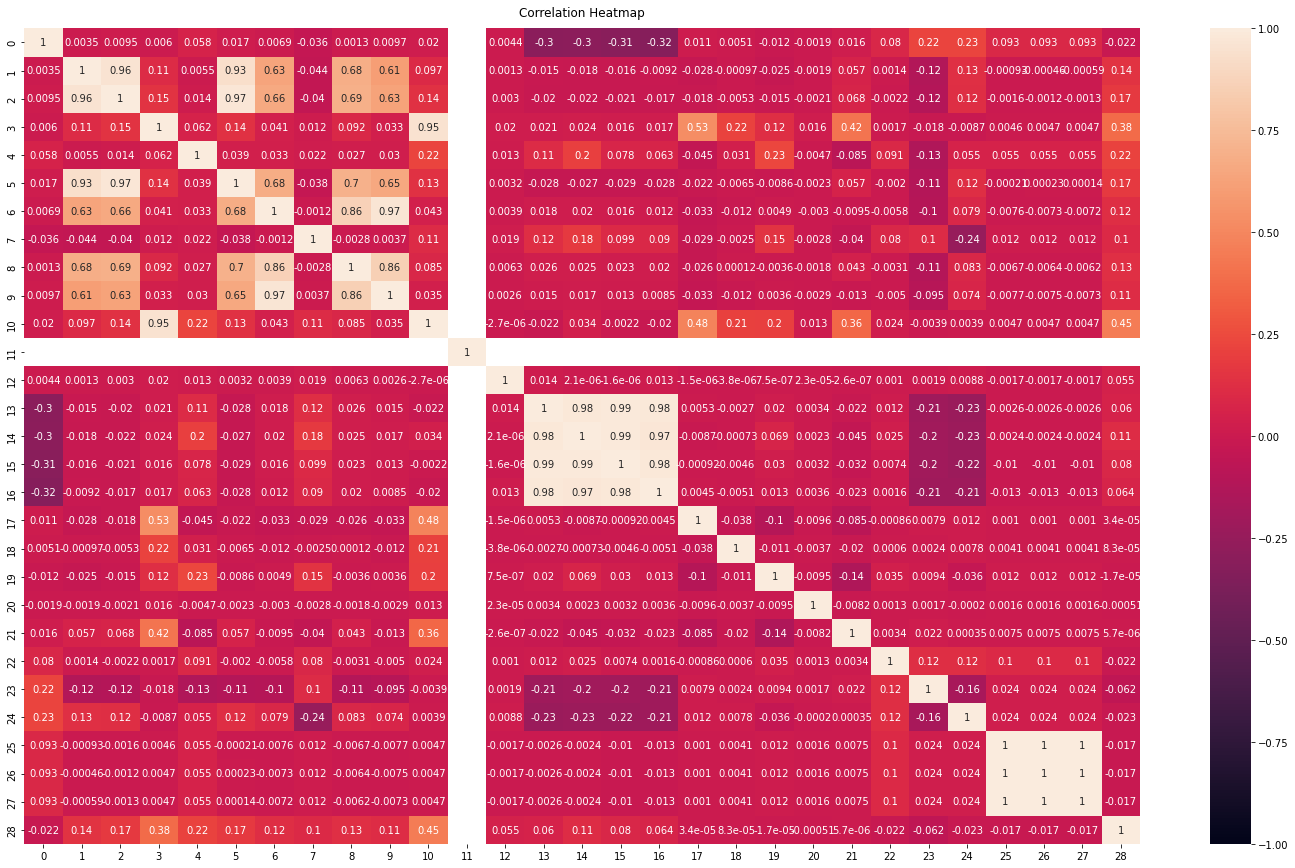

In [40]:
plt.figure(figsize=(25, 15))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(corr_vals, vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

We see that there are some features with negative correlations with respect to our target feature, so we will remove those.

High degree: If the coefficient value lies between ± 0.50 and ± 1, then it is said to be a strong correlation. Moderate degree: If the value lies between ± 0.30 and ± 0.49, then it is said to be a medium correlation. Low degree: When the value lies below + . 29, then it is said to be a small correlation.

Need to figure out if using negative treshold for correlation is a good idea. It looks like the features affecting DEP_DELAY is the ones over

----

Further data analysis....

----

## What will we predict?

We will be predicting flight delays based on data that is available prior to the day of the flight. <br>
Such data could be weather, airport, airline, origin and destination, and other factors.

## TODOs:
- [ ] - Select a regression model, and start predicting.
- [ ] - If we are done early with that we can try to optimize the time spark / hadoop - mapreduce tasks take.
        - [ ] - repartition the data to use right amount cores. (24 cores)